# 
Logistic Regression on the Titanic Dataset

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
%matplotlib inline

In [207]:
train = pd.read_csv('titanic_train.csv')

In [208]:
train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,2,"Weisz, Mrs. Leopold (Mathilde Francoise Pede)",female,29.0,1,0,228414,26.000,NaN,S,1
1,3,"Williams, Mr. Howard Hugh ""Harry""",male,NaN,0,0,A/5 2466,8.050,NaN,S,0
2,2,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,39.0,0,0,250655,26.000,NaN,S,0
3,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S,0
4,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.050,NaN,S,0


Exploratory Data Analysis# 

In [209]:

train.isnull().head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,True,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,True,False,False


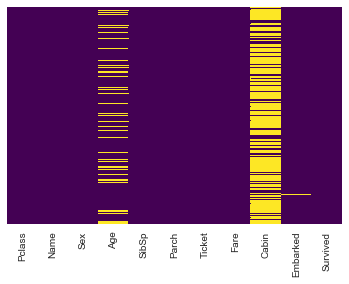

In [210]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [211]:
sns.set_style('whitegrid')

In [212]:

# For classisfication problem it's recommended to check the ratio of target labels.

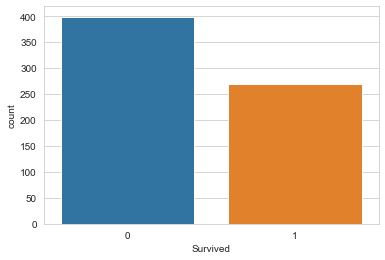

In [213]:

sns.countplot(data=train,x='Survived')

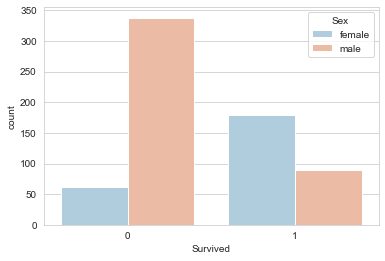

In [214]:

sns.countplot(x='Survived',data=train,hue='Sex',palette='RdBu_r')

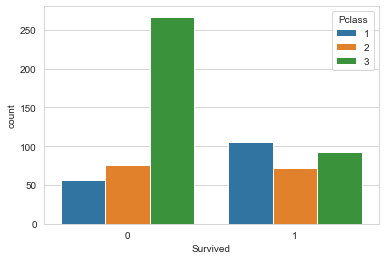

In [215]:
sns.countplot(x='Survived',data=train,hue='Pclass')

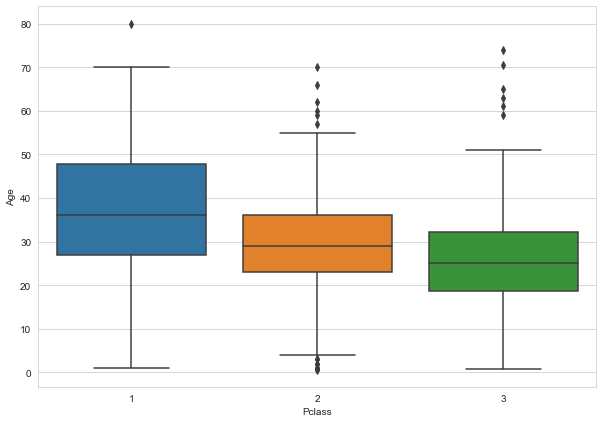

In [216]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass',y='Age',data=train)

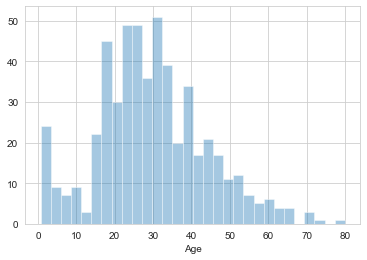

In [217]:
sns.distplot(train['Age'].dropna(),bins=30,kde=False)

There seems to be an interesting bi-modal distribution where there are quite a few young passengers between age 0 and 10. Then the average age tends to be around 20-30.

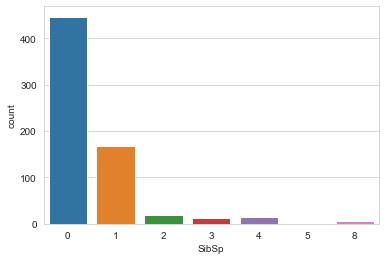

In [218]:
sns.countplot(x='SibSp',data=train)

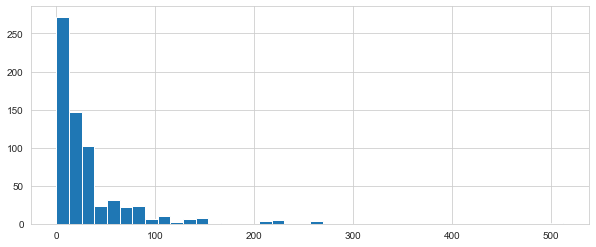

In [219]:
train['Fare'].hist(bins=40,figsize=(10,4))

# Cleaning Data

As we saw earlier there are few columns that are missing some data. We need to clean our dataset before we begin to train our logistic regression model. Lets first try and fill in the missing age values. I'm going to do this by filling in the missing age with the mean age of the passenger class that the passenger belongs to.

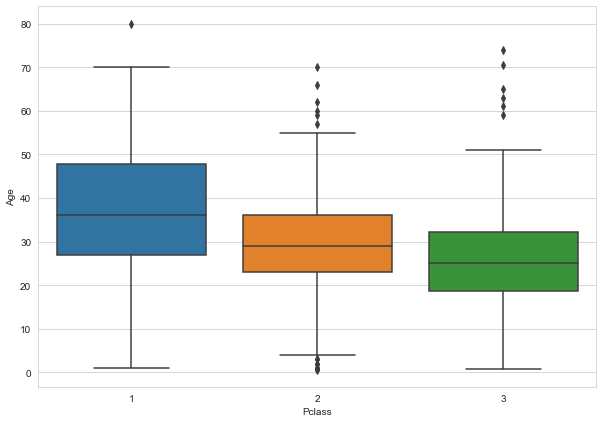

In [220]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass',y='Age',data=train)

In [221]:
train.groupby('Pclass').mean()['Age'].round()

Pclass
1    37.0
2    30.0
3    26.0
Name: Age, dtype: float64

In [222]:

mean_class1 = train.groupby('Pclass').mean()['Age'].round().loc[1]
mean_class2 = train.groupby('Pclass').mean()['Age'].round().loc[2]
mean_class3 = train.groupby('Pclass').mean()['Age'].round().loc[3]

In [223]:
train.loc[train['Pclass']==1,'Age'] = train.loc[train['Pclass']==1,'Age'].fillna(value=mean_class1)
train.loc[train['Pclass']==2,'Age'] = train.loc[train['Pclass']==2,'Age'].fillna(value=mean_class2)
train.loc[train['Pclass']==3,'Age'] = train.loc[train['Pclass']==3,'Age'].fillna(value=mean_class3)

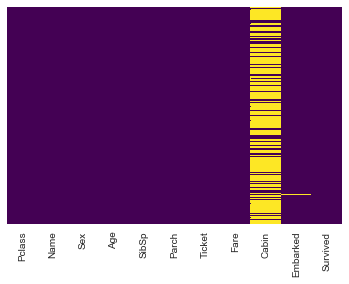

In [224]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

I'm going to just drop the cabin column since there's too much missing information.

In [225]:
train.drop('Cabin',axis=1,inplace=True)

I will now convert some of the categorical features in the dataset into dummy variables that our machine learning model can accept.

In [226]:
sex = pd.get_dummies(train['Sex'],drop_first=True)

In [227]:
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [228]:

train = pd.concat([train,sex,embark],axis=1)

In [229]:
train.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived,male,Q,S
0,2,"Weisz, Mrs. Leopold (Mathilde Francoise Pede)",female,29.0,1,0,228414,26.00,S,1,0,0,1
1,3,"Williams, Mr. Howard Hugh ""Harry""",male,26.0,0,0,A/5 2466,8.05,S,0,1,0,1


In [230]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [231]:
train.head()

,Pclass,Age,SibSp,Parch,Fare,Survived,male,Q,S
0,2,29.0,1,0,26.000,1,0,0,1
1,3,26.0,0,0,8.050,0,1,0,1
2,2,39.0,0,0,26.000,0,1,0,1
3,3,29.0,0,4,21.075,0,0,0,1
4,3,25.0,0,0,7.050,0,1,0,1



Now lets perform similar data cleaning on the test data.

In [232]:
test = pd.read_csv('titanic_test.csv')

In [233]:
test.loc[test['Pclass']==1,'Age'] = test.loc[test['Pclass']==1,'Age'].fillna(value=mean_class1)
test.loc[test['Pclass']==2,'Age'] = test.loc[test['Pclass']==2,'Age'].fillna(value=mean_class2)
test.loc[test['Pclass']==3,'Age'] = test.loc[test['Pclass']==3,'Age'].fillna(value=mean_class3)

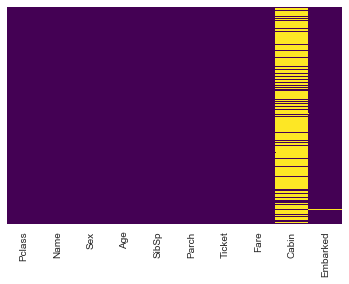

In [234]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [235]:
test.drop('Cabin',axis=1,inplace=True)

In [236]:
sex = pd.get_dummies(test['Sex'],drop_first=True)
embark = pd.get_dummies(test['Embarked'],drop_first=True)

In [237]:

test = pd.concat([test,sex,embark],axis=1)

In [238]:
test.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [239]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,2,8.0,1,1,36.7500,1,0,1
1,1,49.0,0,0,25.9292,0,0,1
2,3,26.0,0,0,7.7375,1,1,0
3,2,24.0,2,1,27.0000,0,0,1
4,1,36.0,0,0,26.2875,1,0,1


Train and build Classifier# 

In [240]:

X = train.drop('Survived',axis=1)
y = train['Survived']
X = train.drop('Q',axis=1)
y = train['Q']
X = train.drop('S',axis=1)
y = train['S']


In [241]:

from sklearn.model_selection import train_test_split

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [243]:

from sklearn.linear_model import LogisticRegression

In [244]:

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [245]:
logmodel.score(X_train,y_train)

0.8201284796573876

In [246]:
logmodel.score(X_test,y_test)

0.7711442786069652

Making Prediction

In [247]:

test_x = test

In [248]:

predictions = logmodel.predict(test_x)

In [249]:
final_prediction = pd.DataFrame({'Survived':predictions})

In [250]:
final_prediction.head()

,Survived
0,0
1,0
2,1
3,0
4,0


In [251]:
np.savetxt("predicted_ccpp.csv", final_prediction, delimiter=',')